In [57]:
%reset -sf

import sys
sys.path.insert(0, '..')
import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

import os
import glob
import shutil

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)
print(tf.__version__)
print(tf.config.list_physical_devices(), end='\n\n')

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [58]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor(processor=20)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 20

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [59]:
## Global variables

GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 512
EPOCHS = 512
LEARNING_RATE = 5e-5

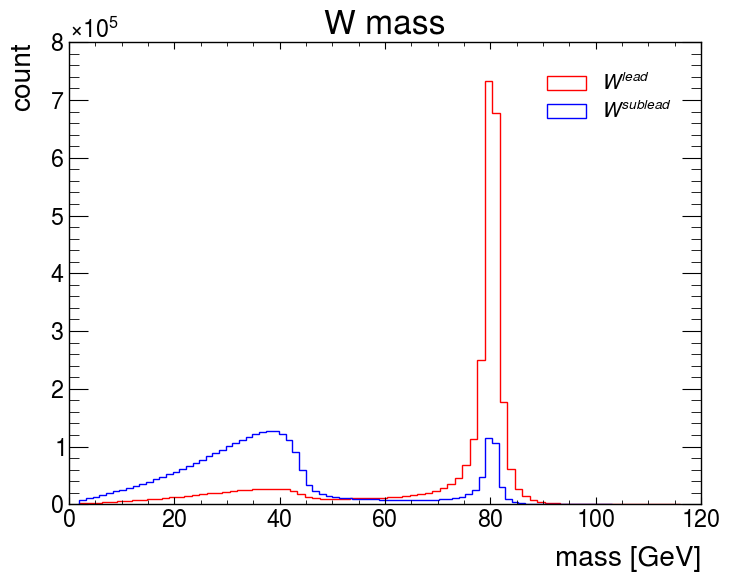

<class 'pandas.core.frame.DataFrame'>
int_kin shape: (1378510, 1)
             E
9   262.774094
26  124.257406
31  121.915047


/tmp/ipykernel_25277/2098174500.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  int_kin = w_lead[["E"]][PRE_CUT] / GEV


In [60]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["E"] == data.LepP["E"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0)
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0)

# Check (sub)lead W
plt.hist(w_lead["m"] / GEV, bins=80, color="r", histtype="step", label=r"$W^{lead}$")
plt.hist(
    w_sublead["m"] / GEV, bins=80, color="b", histtype="step", label=r"$W^{sublead}$"
)
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()

# Kinematics of interesting variables (target for training)
int_kin = w_lead[["E"]][PRE_CUT] / GEV
print(type(int_kin))
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))

In [61]:
## Observing variables

met = data.MET[["px", "py"]]
lead_lep = data.LeadLep[["E", "px", "py", "pz"]]
sublead_lep = data.SubLep[["E", "px", "py", "pz"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print(type(obs_kin))
print("int_kin shape:", obs_kin.shape)
print(obs_kin.head(3))

<class 'pandas.core.frame.DataFrame'>
int_kin shape: (1378510, 10)
             E         px         py          pz          E         px  \
7    43.361348  42.407754  -4.632000    7.767462  19.500895  -4.561588   
9   164.814766  34.397141   2.031300 -161.172625  70.592648  29.001777   
10   90.238664 -23.868604  32.986602   80.530680  47.669113 -26.605045   

           py         pz         px         py  
7   18.924410  -1.154271  96.335650  47.095450  
9    1.896990 -64.332027 -26.992604 -70.883859  
10 -17.256748  35.590859  44.222846 -15.383637  


In [62]:
# Preprocessing of interesting variables
# ROBUST_INT = RobustScaler()
# ROBUST_INT.fit_transform(int_kin)
# MINMAX_INT = MinMaxScaler(feature_range=(0, 1))
# int_kin = MINMAX_INT.fit_transform(int_kin)
STDSCALAR_INT = StandardScaler()
int_kin = STDSCALAR_INT.fit_transform(int_kin)

# Preprocessing of observing variables
# ROBUST_INT = RobustScaler()
# ROBUST_INT.fit_transform(obs_kin)
# MINMAX_INT = MinMaxScaler(feature_range=(0, 1))
# obs_kin = MINMAX_INT.fit_transform(obs_kin)
STDSCALAR_OBS = StandardScaler()
obs_kin = STDSCALAR_OBS.fit_transform(obs_kin)

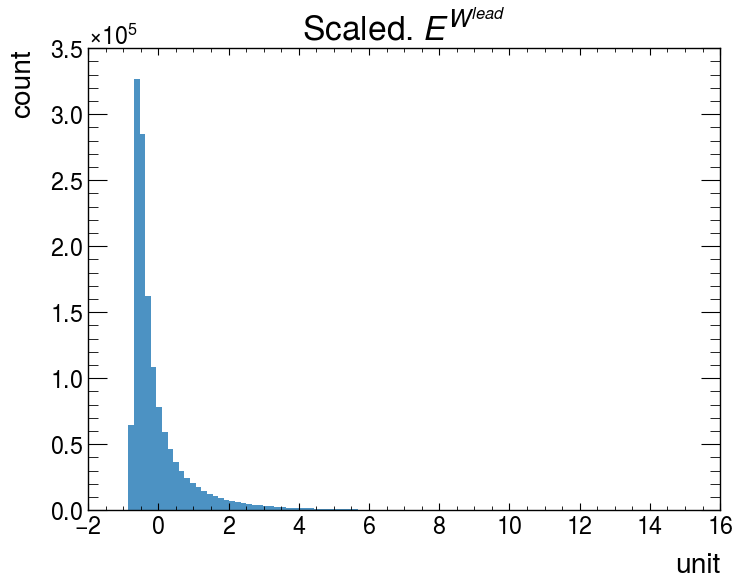

In [63]:
plt.hist(int_kin[:, 0], bins=100, alpha=0.8)
plt.title("Scaled." + r" $E^{W^{lead}}$")
plt.xlabel("unit")
plt.ylabel("count")
plt.show()
plt.close()
# plt.hist(int_kin[:, 1], bins=100, alpha=.8)
# plt.title("Scaled." + r" $p_{z}^{W^{lead}}$")
# plt.xlabel("unit")
# plt.ylabel("count")
# plt.show()
# plt.close()

In [64]:
indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (551404, 10);
Validing data shape: (413553, 10);
Testing data shape: (413553, 10).
Y (Observed)
Training data shape: (551404, 1);
Validing data shape: (413553, 1);
Testing data shape: (413553, 1).



In [65]:
# Define a new activation function
def custom_activation(x):
    return x * tf.keras.backend.sigmoid(x)


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=32, activation="elu")(x)
    x = tf.keras.layers.Dense(units=32, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [66]:
model = build_model()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten_5 (Flatten)         (None, 10)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               1408      
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dense_40 (Dense)            (None, 64)                4160

In [67]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512
1077/1077 - 9s - loss: 1.0143 - val_loss: 1.0029 - 9s/epoch - 8ms/step
Epoch 2/512
1077/1077 - 6s - loss: 1.0012 - val_loss: 1.0026 - 6s/epoch - 6ms/step
Epoch 3/512
1077/1077 - 6s - loss: 0.9999 - val_loss: 1.0027 - 6s/epoch - 6ms/step
Epoch 4/512
1077/1077 - 6s - loss: 0.9997 - val_loss: 1.0025 - 6s/epoch - 6ms/step
Epoch 5/512
1077/1077 - 6s - loss: 0.9992 - val_loss: 1.0025 - 6s/epoch - 6ms/step
Epoch 6/512
1077/1077 - 6s - loss: 0.9992 - val_loss: 1.0025 - 6s/epoch - 6ms/step
Epoch 7/512
1077/1077 - 6s - loss: 0.9991 - val_loss: 1.0025 - 6s/epoch - 6ms/step
Epoch 8/512
1077/1077 - 6s - loss: 0.9991 - val_loss: 1.0025 - 6s/epoch - 6ms/step
Epoch 9/512
1077/1077 - 6s - loss: 0.9991 - val_loss: 1.0024 - 6s/epoch - 6ms/step
Epoch 10/512
1077/1077 - 6s - loss: 0.9990 - val_loss: 1.0026 - 6s/epoch - 6ms/step
Epoch 11/512
1077/1077 - 6s - loss: 0.9990 - val_loss: 1.0025 - 6s/epoch - 6ms/step
Epoch 12/512
1077/1077 - 6s - loss: 0.9990 - val_loss: 1.0024 - 6s/epoch - 6ms/step
E

In [68]:
# Make a directory
dir_name = "./w_lead_result/"
name = "dnn_w_lead_e"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
else:
    os.makedirs(dir_name)

# save model
model.save(dir_name + name + ".h5", save_format="h5", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

    1/12924 [..............................] - ETA: 18:38

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12924/12924 [==============================] - 18s 1ms/step


In [69]:
print(
    f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}, min: {np.min(sig_truth[:,0]):.3f}, max: {np.max(sig_truth[:,0]):.3f}"
)

Truth mean: 0.000, std: 1.000, min: -0.841, max: 13.474


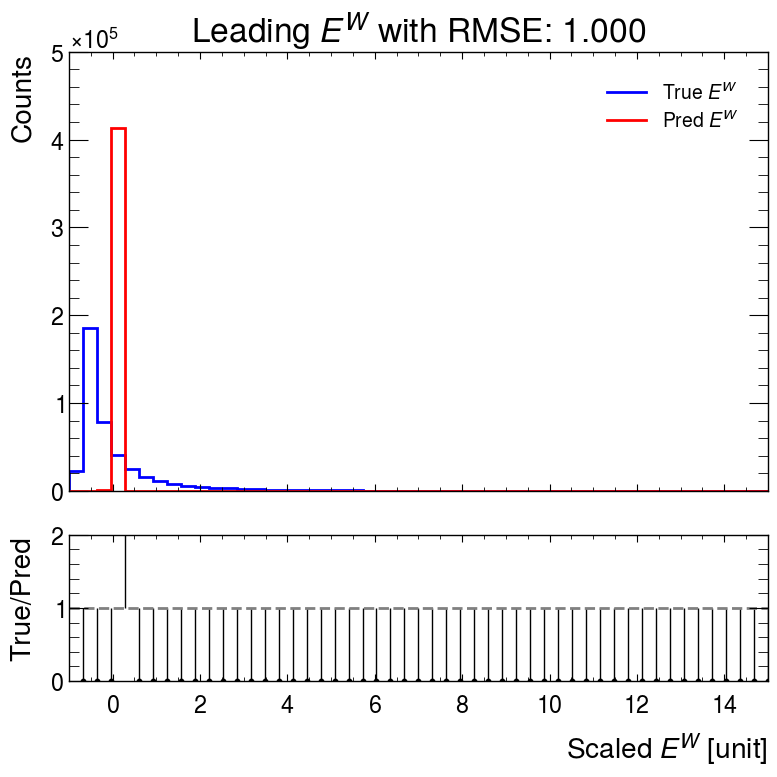

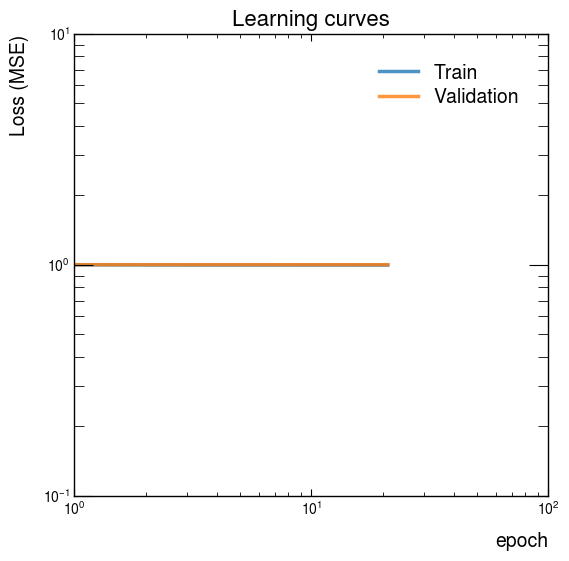

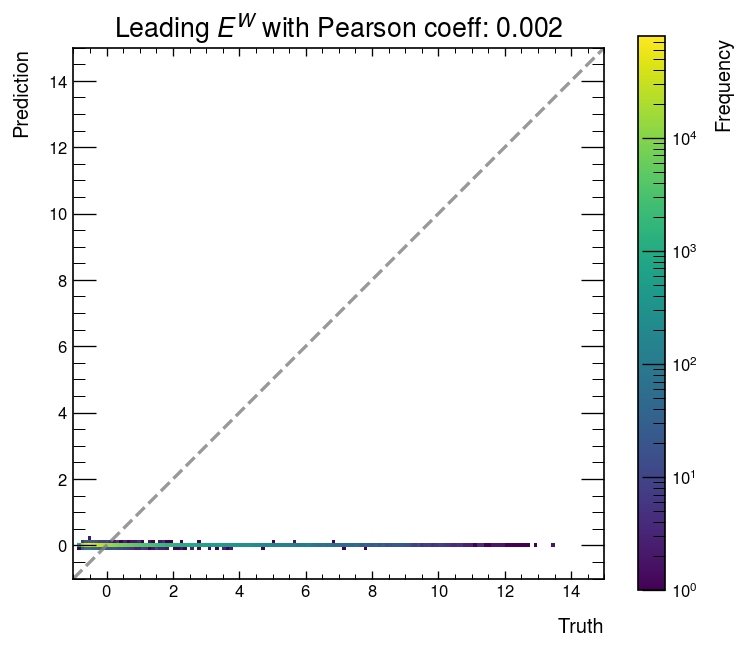

In [70]:
range = [-1, 15]

plot.hist(
    data=[sig_truth[:, 0], sig_pred[:, 0]],
    label=r"$E^{W}$",
    title="Leading $E^{W}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    range=range,
)

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Leading $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)